# Path Planning on Grid (Part 2)
In this lab your task is to conduct an experimental study of how various heuristics (and tie-breakers) influence the performance of A* algorithm in the task of grid-based path finding. 

Before experimenting, you need to prepare a set of input data. It is required to use [[MovingAI](https://movingai.com/benchmarks/grids.html)] benchmark for this purpose. The input data must be approprietaly handled and the results of each individual run must be stored for further analysis.

In this lab we assume that the grid is 8-connected, i.e. moves to both cardinally and diagonally adjacent cells are allowed (and their cost equal the distance between the centers of two cells). However 'cutting corners' is prohibited (as explained later in the lab).

To accomplish the lab you need to change the code in particular cells according to the instructions provided. 

You will also have to write a short essay (in the last text cell) desribing the results you have obtain.

Good luck!

![1](./Image/1.png)

In [1]:
import time

from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
%matplotlib inline
EPS = 0.000001

### Grid map representation and allowed moves on a grid

Square grid map class represents agent's environment

- width -- the number of rows in grid
- height -- the number of columns in grid
- cells -- the binary matrix, which represents the grid. 0 - cell is traversable
1 - cell is blocked

You have to code the getNeigbors fucntions that allows both cardinal and diagonal moves, but dissalows cutting corners and squezzing (see below)

![1](./Image/сutcorners.png)

In [2]:
class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]
    
    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected but cutting corners is prohibited
        '''
        neighbors = []

        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                n_i, n_j = i + di, j + dj
                if self.in_bounds(n_i, n_j) and \
                    self.traversable(n_i, n_j) and \
                    self.traversable(n_i, j) and \
                    self.traversable(i, n_j):
                    neighbors.append((n_i, n_j))

        return neighbors

    def get_size(self):
        return (self._height, self._width)

Computes a cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`

In [3]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of a move between the adjacent cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2: #diagonal move
        return math.sqrt(2)
    else:
        raise Exception('Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.')

### Node representation

Node class represents a search node

- i, j: coordinates of corresponding grid element
- g: g-value of the node
- h: h-value of the node
- F: f-value of the node
- parent: pointer to the parent-node 

In [4]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields/methods for Node
    '''

    def __init__(self, i, j, g = 0, h = 0, F = None, parent = None, k = 0):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent

    def __lt__(self, other):
        return (self.F, self.h) < (other.F, other.h)

    def get_pos(self):
        return self.i, self.j

### Open and close sets implementation
A crucial part of any search algorithm (A* including) is the code for handling OPEN/CLOSED 'lists'. Ineffective implementation of these 'lists' may become a bottleneck, expecially for large instances. So try your best to implement OPEN and CLOSED efficiently and correctly.

In [5]:
import heapq

class Open:

    heap: list[Node]
    nodes: dict[(int, int), Node]

    def __init__(self):
        self.heap = []
        self.nodes = dict()

    def __len__(self):
        return len(self.nodes)

    def __iter__(self):
        return iter(self.nodes.values())

    def is_empty(self):
        return len(self) == 0

    def add_node(self, node: Node):
        pos = node.get_pos()
        if pos in self.nodes:
            if self.nodes[pos].g < node.g:
                return
        heapq.heappush(self.heap, node)
        self.nodes[pos] = node

    def get_best(self):
        while True:
            best = self.heap[0]
            pos = best.get_pos()
            heapq.heappop(self.heap)
            if pos in self.nodes:
                del self.nodes[pos]
                return best


In [6]:
class Closed:

    nodes = dict[(int, int), Node]

    def __init__(self):
        self.nodes = dict()

    def add_node(self, node: Node):
        self.nodes[node.get_pos()] = node

    def __contains__(self, node_pos: (int, int)):
        return node_pos in self.nodes

    def __len__(self):
        return len(self.nodes)

    def __iter__(self):
        return iter(self.nodes.values())


## A* algorithm with different heuristics
Implement 3 different heuristic functions besides the given Manhattan distance - Diagonal distance, Chebyshev distance, Euclidean distance. After that, implement A* using YourOpen and YourClosed.

Importanly, your search algorithm needs to return the following:
- boolean flag indicating whether the path was found or not
- goal state (so you can reconstruct the path later using the parent pointers)
- Open and Closed 'lists' so you can use them for further analysis (i.e. computing how many nodes were created within the search process, how many expansions were made etc.)

In [7]:
def manhattan_distance(i1, j1, i2, j2):
    return abs(abs(int(i1) - int(i2)) + abs(int(j1) - int(j2)))

In [8]:
def diagonal_distance(i1, j1, i2, j2):
    x = abs(i1 - i2)
    y = abs(j1 - j2)
    return min(x, y) * math.sqrt(2) + abs(x - y)


In [9]:
def chebyshev_distance(i1, j1, i2, j2):
    return max(abs(i1 - i2), abs(j1 - j2))

In [10]:
def euclidean_distance(i1, j1, i2, j2):
    return math.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

In [11]:
def astar(grid_map: Map, start_i, start_j, goal_i, goal_j, heuristic_func):
    '''
        Implement A*.
        
        The result should be a tuple:
        - path found/not found (True/False)
        - the goal node (None if path was not found)
        - CLOSED (as per last iteration of the search)
        - OPEN (as per last iteration of the search)
        
    '''
    
    OPEN = Open()
    CLOSED = Closed()

    h0 = heuristic_func(start_i, start_j, goal_i, goal_j)
    OPEN.add_node(Node(start_i, start_j, h=h0))

    while not OPEN.is_empty():
        node = OPEN.get_best()
        CLOSED.add_node(node)
        if node.get_pos() == (goal_i, goal_j):
            return True, node, CLOSED, OPEN
        for nxt_i, nxt_j in grid_map.get_neighbors(node.i, node.j):
            if (nxt_i, nxt_j) not in CLOSED:
                cost = compute_cost(node.i, node.j, nxt_i, nxt_j)
                h = heuristic_func(nxt_i, nxt_j, goal_i, goal_j)
                OPEN.add_node(
                    Node(nxt_i, nxt_j, node.g + cost, h, parent=node)
                )

    return False, None, CLOSED, OPEN


### Make Path
This is an auxiliary function that reconstructs a path (i.e. the sequence on moves from start to goal) given a search tree, created by the search algorithm. It basically unwinds the path using the parent pointers. It also returns a length of the path.

In [12]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

### Simple Single Test
This function helps you to run a test of your search algorithm on a single instance (map + start + goal) and validate the result (provided that you know the correct answer to the path finding query and pass it as a parameter).

In [13]:
def draw_map(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = gridMap._height * k
    wIm = gridMap._width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap._height):
        for j in range(gridMap._width):
            if(gridMap._cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)

    if (goal is not None) and (gridMap.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [14]:
def simple_test(search_function, height, width, map_str, i_start, j_start, i_goal, j_goal, path_len, *args):
    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    start = Node(i_start, j_start)
    goal = Node(i_goal, j_goal)

    try:
        result = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)
        nodes_expanded = result[2]
        nodes_opened = result[3]
        if result[0]:
            path = make_path(result[1])
            correct = abs(path[1] - path_len) < EPS
            draw_map(task_map, start, goal, path[0], nodes_expanded, nodes_opened)
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodes_opened) + len(nodes_expanded)) + ". Number of steps: " + str(len(nodes_expanded)) + ". Correct: " + str(correct))
        else:
            print("Path not found!")
    except Exception as e:
        print("Execution error")
        print(e)

### Proccessing the Input Data and Storing the Results 
Recall that in this lab you have to use [[MovingAI](https://movingai.com/benchmarks/grids.html)] benchmark as a source dataset for you experiments. So you need to implement functions that will read the data from the dataset, running tests (with validating that your answer is a correct one) and store the obtained results for further analysis.


You can use the provided function definitions to organize your work with the benchmark or create your own.

In [15]:
def read_map_from_movingai_file(path):
    with open(path) as f:
        f.readline()
        h = int(f.readline().split()[-1])
        w = int(f.readline().split()[-1])
        f.readline()
        grid = [[0] * w for _ in range(h)]
        for i in range(h):
            line = f.readline()
            for j in range(w):
                if line[j] in '.G':
                    grid[i][j] = 0
                else:
                    grid[i][j] = 1
    res = Map()
    res.set_grid_cells(w, h, grid)
    return res


In [16]:
def read_tasks_from_movingai_file(path):
    tasks = []

    with open(path) as f:
        f.readline()
        for line in f.readlines():
            line = line.split()
            tasks.append([
                int(line[0]), # bucket
                line[1], # name
                int(line[2]), # width,
                int(line[3]), # height
                int(line[5]), # start_i
                int(line[4]), # start_j
                int(line[7]), # goal_i
                int(line[6]), # goal_j
                float(line[8]), # optimal length
            ])

    return tasks 

In [17]:
import os
from tqdm.notebook import tqdm

DATA_DIR = ['Data']

def massive_test(search_function, *args):
    all_tasks_results = dict()
    all_tasks_results["corr"] = []
    all_tasks_results["len"] = []
    all_tasks_results["nc"] = []
    all_tasks_results["st"] = []
    data_dir = DATA_DIR[0]
    maps = dict()
    tasks = []
    for name in os.listdir(data_dir):
        path = os.path.join(data_dir, name)
        if os.path.isfile(path):
            if name.endswith('.map'):
                maps[name] = read_map_from_movingai_file(path)
            elif name.endswith('.scen'):
                tasks.extend(read_tasks_from_movingai_file(path))

    for _, name, w, h, start_i, start_j, goal_i, goal_j, path_len in tqdm(tasks):
        task_map = maps[name]
        start = Node(start_i, start_j)
        goal = Node(goal_i, goal_j)

        try:
            result = search_function(task_map, start.i, start.j, goal.i, goal.j, *args)
            nodes_expanded = result[2]
            nodes_opened = result[3]
            if result[0]:
                path = make_path(result[1])
                all_tasks_results["len"].append(path[1])
                correct = abs(path[1] - path_len) < EPS
                all_tasks_results["corr"].append(correct)
            else:
                all_tasks_results["corr"].append(False)
                all_tasks_results["len"].append(0.0)

            all_tasks_results["nc"].append(len(nodes_opened) + len(nodes_expanded))
            all_tasks_results["st"].append(len(nodes_expanded))
        except Exception as e:
            print("Execution error")
            print(e)

    return all_tasks_results

## Now it's time to run simple test

In [18]:
height = 15
width = 30
map_str = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''
i_start = 1
j_start = 1
i_goal = 13
j_goal = 28
path_len = 31.9705627


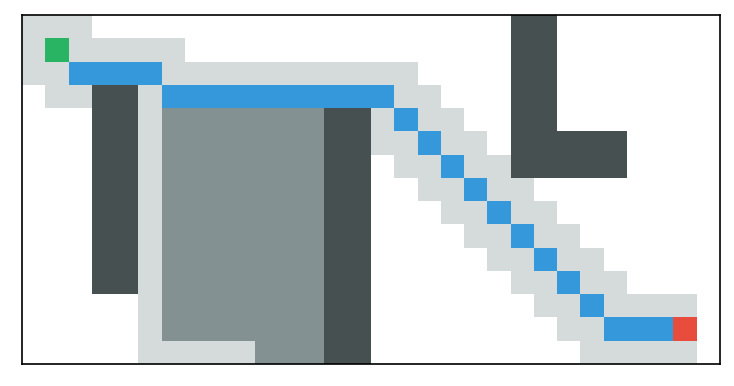

Path found! Length: 31.970562748477146. Nodes created: 187. Number of steps: 101. Correct: True
Wall time: 116 ms


In [19]:
%time simple_test(astar, height, width, map_str, i_start, j_start, i_goal, j_goal, path_len, manhattan_distance)

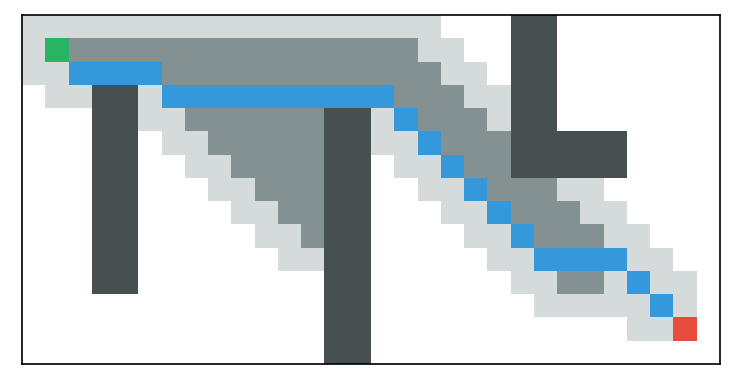

Path found! Length: 31.970562748477146. Nodes created: 177. Number of steps: 98. Correct: True
Wall time: 68.5 ms


In [20]:
%time simple_test(astar, height, width, map_str, i_start, j_start, i_goal, j_goal, path_len, diagonal_distance)

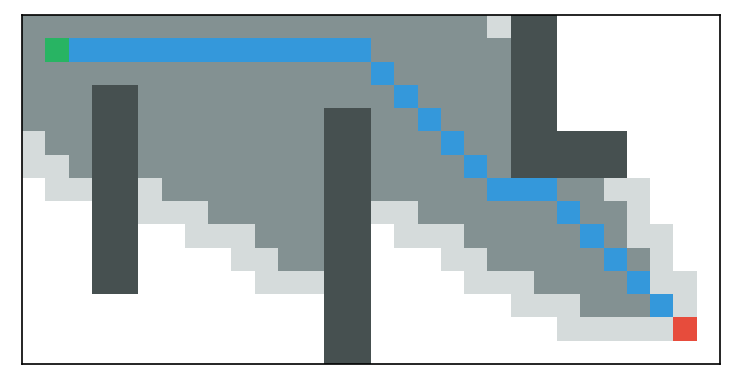

Path found! Length: 31.97056274847715. Nodes created: 234. Number of steps: 189. Correct: True
Wall time: 50.1 ms


In [21]:
%time simple_test(astar, height, width, map_str, i_start, j_start, i_goal, j_goal, path_len, chebyshev_distance)

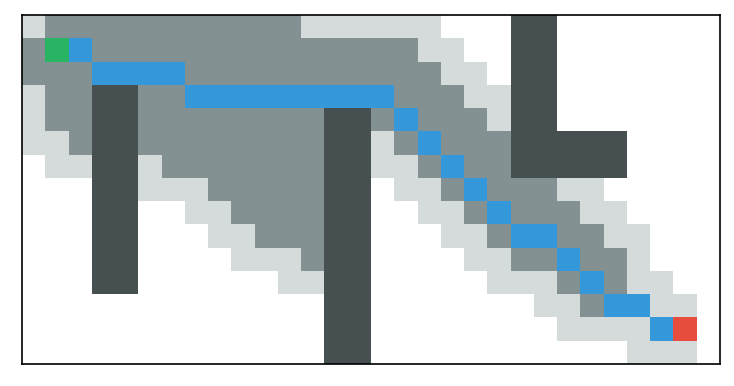

Path found! Length: 31.970562748477146. Nodes created: 210. Number of steps: 143. Correct: True
Wall time: 63.2 ms


In [22]:
%time simple_test(astar, height, width, map_str, i_start, j_start, i_goal, j_goal, path_len, euclidean_distance) 

## Massive test
Now you need to run your search algorithm utilizing different heuristic functions on a range of different instances from the [[MovingAI](https://movingai.com/benchmarks/grids.html)] benchmark, validate that you get the correct solution in each case and analyze the results.

Minimum number of different maps from the benchmark that should be used for testing is **3**.

Minumum number of different instances (start-goal pairs) for each map is **100**.

![2](./Image/3.png)

In [23]:
# TODO Run tests using 4 different heuristics
manhStat = massive_test(astar, manhattan_distance)
diagStat = massive_test(astar, diagonal_distance)
chebStat = massive_test(astar, chebyshev_distance)
euclidStat = massive_test(astar, euclidean_distance)

  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

## Analyze the results
Aggregate the results (think of a plausible way of doing this) and present them as plots. 

Write a short text report in a separate cell(s), containing a description of the results and the hypotheses that explains them.

manh: {'corr': 0.8530487804878049, 'len': 160.0491246592252, 'nc': 1547.7554878048782, 'st': 1281.1646341463415}
diag: {'corr': 1.0, 'len': 159.47630464553953, 'nc': 2889.653048780488, 'st': 2679.996951219512}
cheb: {'corr': 1.0, 'len': 159.47630464553953, 'nc': 4002.6554878048782, 'st': 3845.503048780488}
euclid: {'corr': 1.0, 'len': 159.47630464553953, 'nc': 3492.816463414634, 'st': 3311.506707317073}
manh: {'corr': 0.8384615384615385, 'len': 26.32111275684448, 'nc': 93.03076923076924, 'st': 25.823076923076922}
diag: {'corr': 1.0, 'len': 26.086477946714158, 'nc': 123.33846153846154, 'st': 56.184615384615384}
cheb: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 323.5076923076923, 'st': 254.36153846153846}
euclid: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 202.14615384615385, 'st': 132.6}


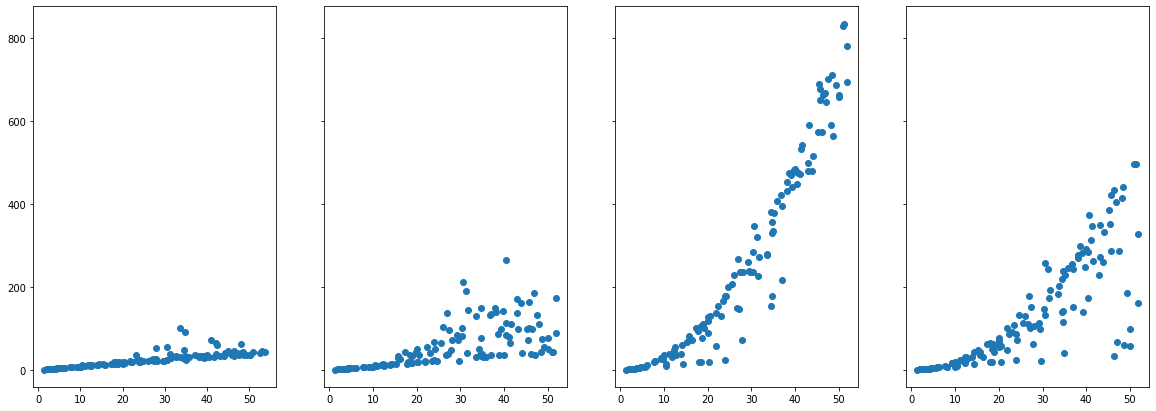

In [27]:
def agg(stat):
    result = dict()
    result['corr'] = np.mean(stat['corr'])
    result['len'] = np.mean(stat['len'])
    result['nc'] = np.mean(stat['nc'])
    result['st'] = np.mean(stat['st'])
    return result

print('manh:', agg(manhStat))
print('diag:', agg(diagStat))
print('cheb:', agg(chebStat))
print('euclid:', agg(euclidStat))

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(20,7), sharey=True)
ax.scatter(manhStat['len'], manhStat['st'])
bx.scatter(diagStat['len'], diagStat['st'])
cx.scatter(chebStat['len'], chebStat['st'])
dx.scatter(euclidStat['len'], euclidStat['st'])
plt.show()


What is the best heuristics for this domain? Why?

Манхеттенское расстояние в качестве эвристики быстро находит решение (раскрывает меньше вершин и делает меньше итерации), но не всегда корректно (85% верных путей), это связанно с тем, что эта эвристика не admissible, но при этом она наибольшая из всех эвристик (как функция), поэтому меньше раскрытых вершин.

Остальные эвристики "правильные" и показывают 100% корректность, но кол-во раскрытых вершин и итерации наименьшее у диагональной эвристики, т.к. она наибольшая (как функция) из всех правильных.

## Tie-breakers



Now you need to run experiments with the best performing heuristics but different tie-breakers and analyze the results. Choose 1 map and run experiments on it, collect statistics, present it (plots, tables etc.) and elaborate on the obtained results (=write a short text in a separate cell).

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

manh: {'corr': 0.8461538461538461, 'len': 26.298582509243445, 'nc': 93.53846153846153, 'st': 26.23846153846154}
diag: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 167.19230769230768, 'st': 98.86153846153846}
cheb: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 330.3076923076923, 'st': 259.7153846153846}
euclid: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 207.44615384615383, 'st': 138.08461538461538}


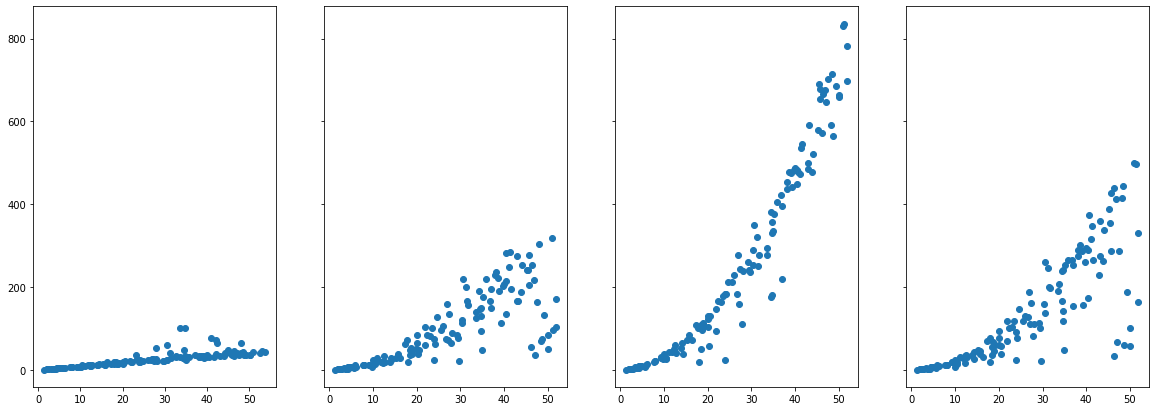

In [28]:
DATA_DIR[0] = 'DataTie'

def by_g(self, other):
    return (self.F, self.g) < (other.F, other.g)

Node.__lt__ = by_g

manhStat = massive_test(astar, manhattan_distance)
diagStat = massive_test(astar, diagonal_distance)
chebStat = massive_test(astar, chebyshev_distance)
euclidStat = massive_test(astar, euclidean_distance)

print('manh:', agg(manhStat))
print('diag:', agg(diagStat))
print('cheb:', agg(chebStat))
print('euclid:', agg(euclidStat))

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(20,7), sharey=True)
ax.scatter(manhStat['len'], manhStat['st'])
bx.scatter(diagStat['len'], diagStat['st'])
cx.scatter(chebStat['len'], chebStat['st'])
dx.scatter(euclidStat['len'], euclidStat['st'])
plt.show()

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

manh: {'corr': 0.8384615384615385, 'len': 26.32111275684448, 'nc': 93.03076923076924, 'st': 25.823076923076922}
diag: {'corr': 1.0, 'len': 26.086477946714158, 'nc': 123.33846153846154, 'st': 56.184615384615384}
cheb: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 323.5076923076923, 'st': 254.36153846153846}
euclid: {'corr': 1.0, 'len': 26.086477946714155, 'nc': 202.14615384615385, 'st': 132.6}


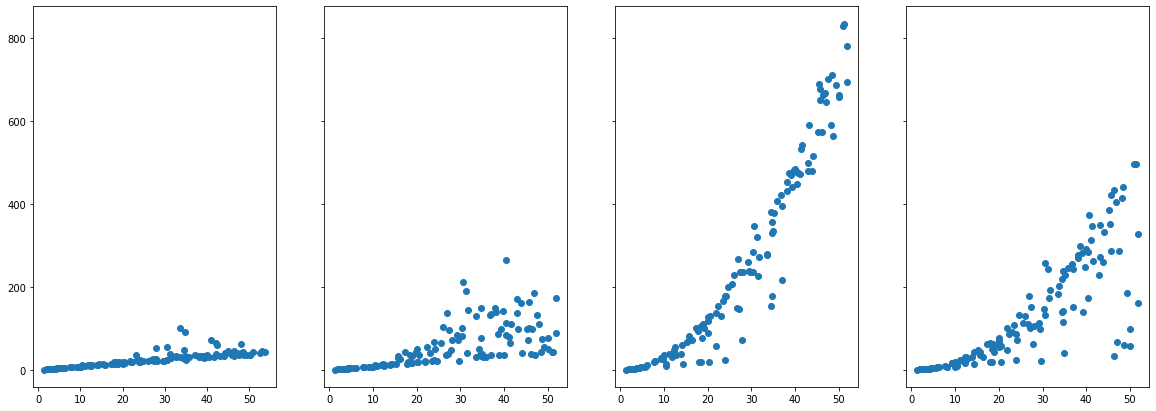

In [29]:

def by_h(self, other):
    return (self.F, self.h) < (other.F, other.h)

Node.__lt__ = by_h

manhStat = massive_test(astar, manhattan_distance)
diagStat = massive_test(astar, diagonal_distance)
chebStat = massive_test(astar, chebyshev_distance)
euclidStat = massive_test(astar, euclidean_distance)

print('manh:', agg(manhStat))
print('diag:', agg(diagStat))
print('cheb:', agg(chebStat))
print('euclid:', agg(euclidStat))

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(20,7), sharey=True)
ax.scatter(manhStat['len'], manhStat['st'])
bx.scatter(diagStat['len'], diagStat['st'])
cx.scatter(chebStat['len'], chebStat['st'])
dx.scatter(euclidStat['len'], euclidStat['st'])
plt.show()

##### Вывод:

1. Если "доверять" эвристике (то есть выбирать по $h$), то кол-во итераций и кол-во раскрытых вершин уменьшается.
2. Для манхеттенской эвристики если "доверять" эвристике, то корректность уменьшается, видимо потому что эвристика "плохая".
